In [1]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from shapely.geometry import mapping

C:\Users\taohuang\AppData\Local\anaconda3\Lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files.  Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()
C:\Users\taohuang\AppData\Local\Temp\ipykernel_43388\4128980056.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Polygon", y="Value", data=df, palette="Set3", linewidth=1.5, order = order)


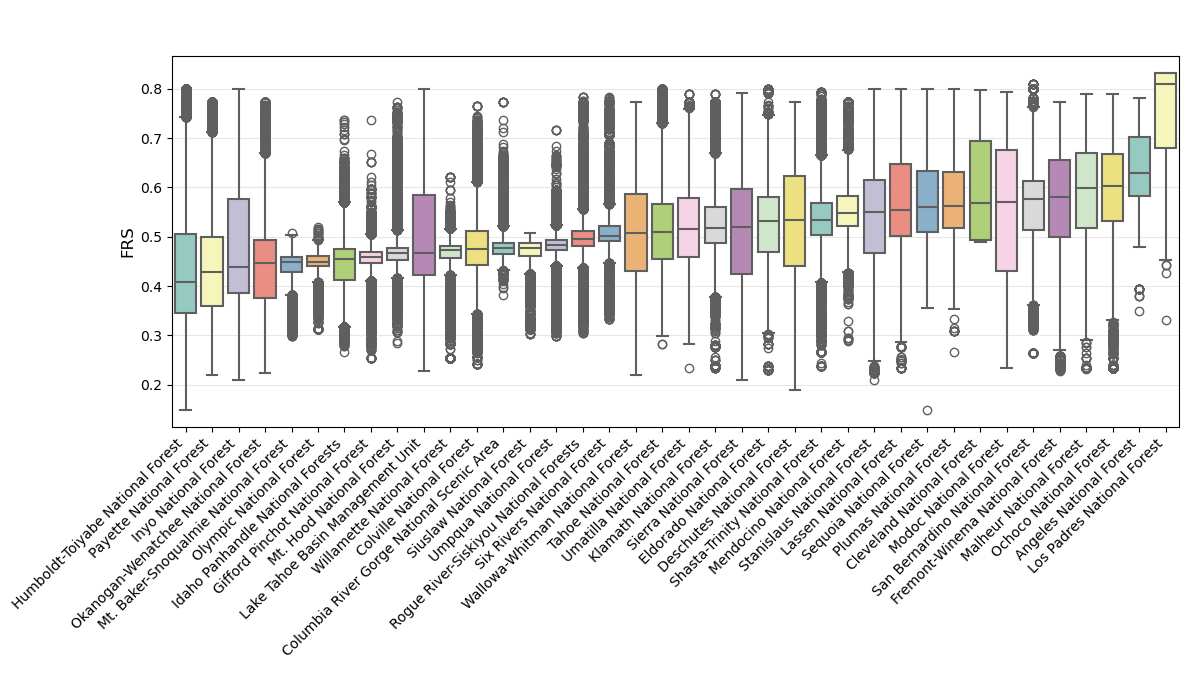


Summary statistics per polygon:
                                            mean    std    min    25%    50%  \
Polygon                                                                        
Angeles National Forest                    0.641  0.078  0.350  0.582  0.630   
Cleveland National Forest                  0.597  0.093  0.489  0.494  0.569   
Columbia River Gorge National Scenic Area  0.486  0.036  0.382  0.466  0.478   
Colville National Forest                   0.475  0.065  0.243  0.444  0.474   
Deschutes National Forest                  0.532  0.119  0.189  0.440  0.534   
Eldorado National Forest                   0.524  0.078  0.231  0.469  0.531   
Fremont-Winema National Forest             0.573  0.105  0.227  0.499  0.580   
Gifford Pinchot National Forest            0.453  0.030  0.255  0.446  0.459   
Humboldt-Toiyabe National Forest           0.441  0.135  0.149  0.346  0.409   
Idaho Panhandle National Forests           0.441  0.057  0.266  0.412  0.455   
Inyo Na

In [2]:
# -----------------------------
# 1. Set your file paths
# -----------------------------
raster_path = r"C:\Users\taohuang\Downloads\frs_spatial.tif" #"data/ndvi_2023.tif"        # Change to your raster
shapefile_path =  r"C:\Users\taohuang\Downloads\westcoast_forests.shp" #"data/sample_polygons.shp"  # Your polygons

# Optional: give nice names (use a column in your shapefile like 'name', 'id', 'class')
label_column = 'FORESTNAME'   # e.g., 'Plot_ID', 'Field', 'Zone', etc. Change accordingly!

# -----------------------------
# 2. Read data
# -----------------------------
gdf = gpd.read_file(shapefile_path)

with rasterio.open(raster_path) as src:
    raster_crs = src.crs
    nodata = src.nodata

# Reproject polygons to raster CRS if needed
if gdf.crs != raster_crs:
    gdf = gdf.to_crs(raster_crs)

# -----------------------------
# 3. Extract values for each polygon
# -----------------------------
data_for_plotting = []

with rasterio.open(raster_path) as src:
    for idx, row in gdf.iterrows():
        try:
            # Crop and mask raster to polygon
            geom = [mapping(row.geometry)]
            out_image, _ = mask(src, geom, crop=True, filled=True, nodata=nodata)
            
            # Extract values (assuming single band; change [0] for multi-band)
            values = out_image[0].ravel()
            
            # Remove nodata and NaN
            if nodata is not None:
                values = values[values != nodata]
            values = values[np.isfinite(values)]
            
            # Get label for this polygon
            label = row[label_column] if label_column in row else f"Poly_{idx}"
            
            # Append to list for plotting
            if len(values) > 0:
                for val in values:
                    data_for_plotting.append({"Polygon": label, "Value": val})
                    
        except Exception as e:
            print(f"Polygon {idx} failed: {e}")

# Convert to DataFrame
df = pd.DataFrame(data_for_plotting)


# Step 1: Compute median per group
medians = df.groupby('Polygon')['Value'].median()   # change 'category' and 'value' to your column names

# Step 2: Get the order (ascending or descending)
order = medians.sort_values(ascending=True).index

# -----------------------------
# 4. Plot boxplot (or violinplot)
# -----------------------------
plt.figure(figsize=(12, 7))

# Option A: Classic boxplot
sns.boxplot(x="Polygon", y="Value", data=df, palette="Set3", linewidth=1.5, order = order)

# Option B: Violinplot (uncomment to use instead)
# sns.violinplot(x="Polygon", y="Value", data=df, palette="muted", inner="quartile")

# Option C: Boxplot + swarmplot (shows individual points)
# sns.boxplot(x="Polygon", y="Value", data=df, palette="Set3", whis=1.5)
# sns.swarmplot(x="Polygon", y="Value", data=df, color="black", alpha=0.6, size=3)

plt.title(" ", fontsize=16, pad=20)
plt.xlabel(" ", fontsize=12)
plt.ylabel("FRS", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# -----------------------------
# 5. (Optional) Save summary statistics
# -----------------------------
summary = df.groupby("Polygon")["Value"].describe()[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
print("\nSummary statistics per polygon:")
print(summary.round(3))

# Save to CSV
#summary.to_csv("polygon_raster_statistics.csv")
#df.to_csv("all_extracted_values.csv", index=False)